In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [34]:
!pip3 install torchinfo


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [217]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from random import randrange

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /Users/ezequielfernandez/Desktop/dev/nlp/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:33<00:00, 254kB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Limpieza de datos

In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


Rating entre 0 y 4

In [6]:
df_reviews['Rating'].value_counts()

Rating
4    12540
3     4908
2     2823
1     1549
0      821
Name: count, dtype: int64

Vemos que las clases estan notoriamente desbalanceadas

<Axes: ylabel='Frequency'>

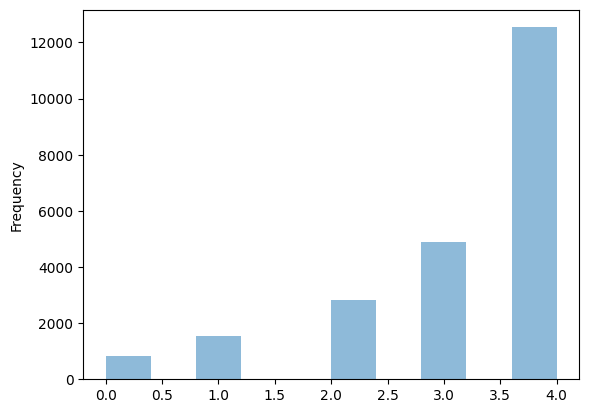

In [7]:
df_reviews['Rating'].plot.hist(bins=10, alpha=0.5)

Vemos que si unimos las clases 0, 1 y 2, que conceptualmente serian una calificacion mala, se empareja un poco el dataset. Usaremos esto para probar modelos, aunque la idea es buscar un modelo que clasifique en todas las clases disponibles

<Axes: ylabel='Frequency'>

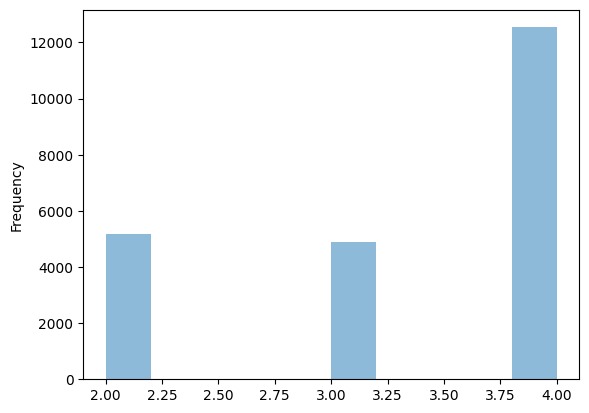

In [8]:
joined_df = df_reviews.copy()

mask = joined_df['Rating'] <= 2
column_name = 'Rating'
joined_df.loc[mask, column_name] = 2

joined_df['Rating'].plot.hist(bins=10, alpha=0.5)

Preparo el corpus

In [9]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [10]:
text_sequences

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       "This fit well, but the top was very see through. this never would have worked for me. i

In [11]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [12]:
# ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [13]:
# Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [14]:
# Vemos los primeros 20 tokens
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [15]:
# ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [18]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [19]:
from itertools import islice

list(islice(word_index.items(), 5))

[('the', 1), ('i', 2), ('and', 3), ('a', 4), ('it', 5)]

In [20]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [21]:
sequences[0]

[253, 532, 917, 3, 662, 3, 68]

In [22]:
# Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [23]:
from tensorflow.keras.utils import pad_sequences
maxlen = 115

In [61]:
# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [62]:
# Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [63]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 253, 532, 917,   3, 662,   3,  68], dtype=int32)

In [27]:
df_reviews['Rating'].value_counts() 

Rating
4    12540
3     4908
2     2823
1     1549
0      821
Name: count, dtype: int64

In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(joined_df['Rating'].to_numpy().reshape(-1,1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [79]:
print(y.shape)

(22641, 3)


In [30]:
from sklearn.model_selection import train_test_split

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # la loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 115
Output dim 3


In [52]:
data_set.__getitem__(0)

(tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 253, 532, 917,   3,
         662,   3,  68], dtype=torch.int32),
 tensor([0., 0., 0., 1., 0.]))

In [33]:
# Utilizamos "random_split" para crear los datos de train y test
# partir del conjunto de datos_set
# Fijamos un "seed" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
torch.manual_seed(42)
data_set_reduced_size = int(data_set.len * 0.4)
valid_set_size = int(data_set_reduced_size * 0.2)
train_set_size = data_set_reduced_size - valid_set_size
data_set_reduced, _ = torch.utils.data.random_split(data_set, [data_set_reduced_size, data_set.len - data_set_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_reduced, [train_set_size, data_set_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Tamaño del conjunto de entrenamiento: 7245
Tamaño del conjunto de validacion: 1811


In [37]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2023-04-27 22:34:12--  http://torch_helpers.py/
Resolviendo torch_helpers.py (torch_helpers.py)... falló: nodename nor servname provided, or not known.
wget: no se pudo resolver la dirección del equipo «torch_helpers.py»
--2023-04-27 22:34:12--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.109.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 23883 (23K) [text/plain]
Grabando a: «torch_helpers.py»

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    en 0.001s  

2023-04-27 22:34:15 (28.8 MB/s) - «torch_helpers.py» guardado [23883/23883]

ACABADO --2023-04-27 22:34:15--
Tiempo total de reloj: 3.3s
Descargados: 1 ficheros, 23K en 0.001s (28.8 MB/s)


In [38]:
from torch_helpers import binary_acc
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

Primer modelo propuesto, profundad baja

In [39]:
import torch.nn as nn
from torchinfo import summary

class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size + 1 para padding o UNK
        # embedding_dim = 50 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding_dim = 50
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.MultiLabelSoftMarginLoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 3]                    --
├─Embedding: 1-1                         [1, 115, 50]              100,050
├─LSTM: 1-2                              [1, 115, 64]              62,976
├─Linear: 1-3                            [1, 128]                  8,320
├─ReLU: 1-4                              [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 3]                    387
├─Sigmoid: 1-7                           [1, 3]                    --
Total params: 171,733
Trainable params: 171,733
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.69
Estimated Total Size (MB): 0.79

Epoch: 1/50 - Train loss 0.692 - Train accuracy 0.550 - Valid Loss 0.696 - Valid accuracy 0.500
Epoch: 2/50 - Train loss 0.692 - Train accuracy 0.549 - Valid Loss 0.687 - Valid accuracy 0.625
Epoch: 3/50 - Train loss 0.686 - Train accuracy 0.550 - Valid Loss 0.694 - Valid accuracy 0.406
Epoch: 4/50 - Train loss 0.670 - Train accuracy 0.549 - Valid Loss 0.691 - Valid accuracy 0.406
Epoch: 5/50 - Train loss 0.664 - Train accuracy 0.550 - Valid Loss 0.659 - Valid accuracy 0.562
Epoch: 6/50 - Train loss 0.664 - Train accuracy 0.549 - Valid Loss 0.673 - Valid accuracy 0.438
Epoch: 7/50 - Train loss 0.661 - Train accuracy 0.549 - Valid Loss 0.654 - Valid accuracy 0.625
Epoch: 8/50 - Train loss 0.659 - Train accuracy 0.549 - Valid Loss 0.670 - Valid accuracy 0.500
Epoch: 9/50 - Train loss 0.658 - Train accuracy 0.550 - Valid Loss 0.685 - Valid accuracy 0.469
Epoch: 10/50 - Train loss 0.657 - Train accuracy 0.549 - Valid Loss 0.655 - Valid accuracy 0.469
Epoch: 11/50 - Train loss 0.656 - Train

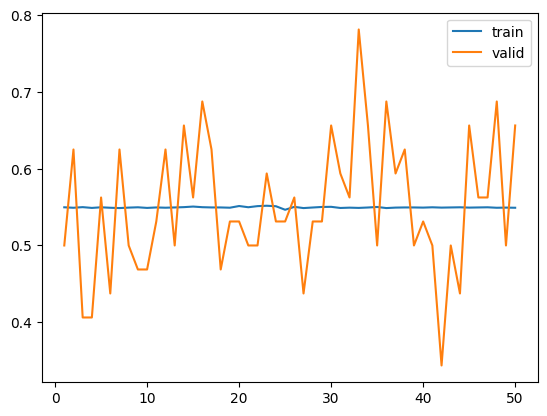

In [41]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=50
                )

epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

El resultado anterior se dio con joined_df que era el dataset simplificado unificando las clases 0,1 y 2

Vemos ahora con el dataset original

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should on

(22641, 5)
input_size: 115
Output dim 5
Tamaño del conjunto de entrenamiento: 7245
Tamaño del conjunto de validacion: 1811
Epoch: 1/30 - Train loss 0.709 - Train accuracy 0.526 - Valid Loss 0.692 - Valid accuracy 0.594
Epoch: 2/30 - Train loss 0.693 - Train accuracy 0.550 - Valid Loss 0.691 - Valid accuracy 0.625
Epoch: 3/30 - Train loss 0.692 - Train accuracy 0.549 - Valid Loss 0.693 - Valid accuracy 0.500
Epoch: 4/30 - Train loss 0.692 - Train accuracy 0.550 - Valid Loss 0.691 - Valid accuracy 0.656
Epoch: 5/30 - Train loss 0.692 - Train accuracy 0.549 - Valid Loss 0.695 - Valid accuracy 0.438
Epoch: 6/30 - Train loss 0.690 - Train accuracy 0.549 - Valid Loss 0.669 - Valid accuracy 0.594
Epoch: 7/30 - Train loss 0.679 - Train accuracy 0.549 - Valid Loss 0.665 - Valid accuracy 0.625
Epoch: 8/30 - Train loss 0.676 - Train accuracy 0.550 - Valid Loss 0.671 - Valid accuracy 0.531
Epoch: 9/30 - Train loss 0.674 - Train accuracy 0.550 - Valid Loss 0.672 - Valid accuracy 0.438
Epoch: 10/30 

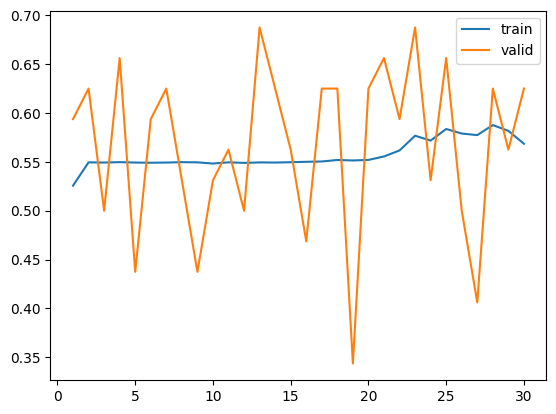

In [80]:
ohe = OneHotEncoder(sparse=False)
original_y = ohe.fit_transform(df_reviews['Rating'].to_numpy().reshape(-1,1))
print(original_y.shape)

data_set_2 = Data(X, original_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(42)
data_set_2_reduced_size = int(data_set_2.len * 0.4)
valid_set_size = int(data_set_2_reduced_size * 0.2)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

Como estrategia para balancear el dataset, pruebo con limtiar el dataset para que cada clase tenga la misma cantidad, usando la de la clase minoritaria

In [84]:
df_reviews['Rating'].value_counts()

Rating
4    12540
3     4908
2     2823
1     1549
0      821
Name: count, dtype: int64

In [87]:
minimized_df = df_reviews.groupby('Rating').head(821)

minimized_df['Rating'].value_counts()

Rating
3    821
4    821
2    821
1    821
0    821
Name: count, dtype: int64

In [90]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = minimized_df['Review Text'].values
text_sequences.shape

corpus = ' '.join(text_sequences)

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)
minimized_X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
ohe = OneHotEncoder(sparse=False)
minimized_y = ohe.fit_transform(minimized_df['Rating'].to_numpy().reshape(-1,1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


input_size: 115
Output dim 5
Tamaño del conjunto de entrenamiento: 1314
Tamaño del conjunto de validacion: 328


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Epoch: 1/30 - Train loss 0.775 - Train accuracy 0.190 - Valid Loss 0.694 - Valid accuracy 0.125
Epoch: 2/30 - Train loss 0.693 - Train accuracy 0.212 - Valid Loss 0.693 - Valid accuracy 0.094
Epoch: 3/30 - Train loss 0.693 - Train accuracy 0.216 - Valid Loss 0.693 - Valid accuracy 0.312
Epoch: 4/30 - Train loss 0.693 - Train accuracy 0.196 - Valid Loss 0.693 - Valid accuracy 0.219
Epoch: 5/30 - Train loss 0.693 - Train accuracy 0.194 - Valid Loss 0.693 - Valid accuracy 0.125
Epoch: 6/30 - Train loss 0.693 - Train accuracy 0.211 - Valid Loss 0.693 - Valid accuracy 0.094
Epoch: 7/30 - Train loss 0.693 - Train accuracy 0.192 - Valid Loss 0.693 - Valid accuracy 0.156
Epoch: 8/30 - Train loss 0.693 - Train accuracy 0.193 - Valid Loss 0.693 - Valid accuracy 0.344
Epoch: 9/30 - Train loss 0.693 - Train accuracy 0.193 - Valid Loss 0.693 - Valid accuracy 0.219
Epoch: 10/30 - Train loss 0.693 - Train accuracy 0.205 - Valid Loss 0.693 - Valid accuracy 0.125
Epoch: 11/30 - Train loss 0.693 - Train

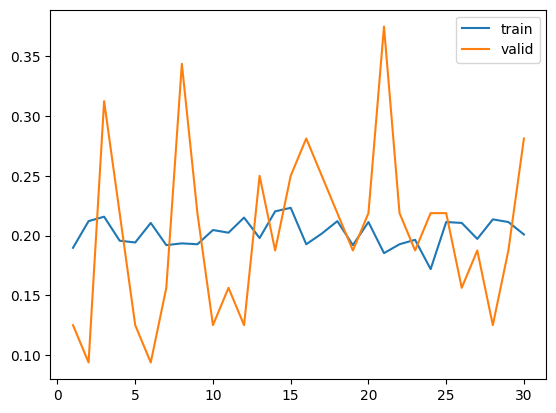

In [91]:
data_set_2 = Data(minimized_X, minimized_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(42)
data_set_2_reduced_size = int(data_set_2.len * 0.4)
valid_set_size = int(data_set_2_reduced_size * 0.2)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

Equilibramos con una clase mas abarcativa

In [92]:
minimized_df = df_reviews.groupby('Rating').head(2823)

minimized_df['Rating'].value_counts()

Rating
3    2823
4    2823
2    2823
1    1549
0     821
Name: count, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should on

input_size: 115
Output dim 5
Tamaño del conjunto de entrenamiento: 3468
Tamaño del conjunto de validacion: 867
Epoch: 1/30 - Train loss 0.725 - Train accuracy 0.245 - Valid Loss 0.693 - Valid accuracy 0.219
Epoch: 2/30 - Train loss 0.693 - Train accuracy 0.256 - Valid Loss 0.693 - Valid accuracy 0.219
Epoch: 3/30 - Train loss 0.693 - Train accuracy 0.245 - Valid Loss 0.693 - Valid accuracy 0.250
Epoch: 4/30 - Train loss 0.693 - Train accuracy 0.250 - Valid Loss 0.693 - Valid accuracy 0.188
Epoch: 5/30 - Train loss 0.693 - Train accuracy 0.248 - Valid Loss 0.693 - Valid accuracy 0.344
Epoch: 6/30 - Train loss 0.693 - Train accuracy 0.250 - Valid Loss 0.693 - Valid accuracy 0.375
Epoch: 7/30 - Train loss 0.693 - Train accuracy 0.247 - Valid Loss 0.693 - Valid accuracy 0.406
Epoch: 8/30 - Train loss 0.693 - Train accuracy 0.250 - Valid Loss 0.693 - Valid accuracy 0.219
Epoch: 9/30 - Train loss 0.693 - Train accuracy 0.255 - Valid Loss 0.693 - Valid accuracy 0.281
Epoch: 10/30 - Train loss

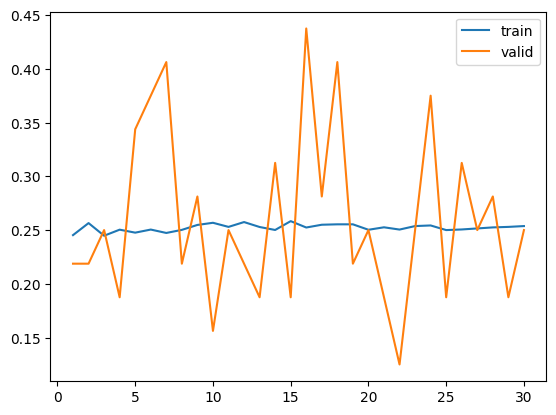

In [93]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = minimized_df['Review Text'].values
text_sequences.shape

corpus = ' '.join(text_sequences)

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)
minimized_X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
ohe = OneHotEncoder(sparse=False)
minimized_y = ohe.fit_transform(minimized_df['Rating'].to_numpy().reshape(-1,1))

data_set_2 = Data(minimized_X, minimized_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(42)
data_set_2_reduced_size = int(data_set_2.len * 0.4)
valid_set_size = int(data_set_2_reduced_size * 0.2)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

Defino un modelo mas complejo

In [94]:
import torch.nn as nn
from torchinfo import summary

class Model2(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size + 1 para padding o UNK
        # embedding_dim = 50 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding_dim = 50
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=256) # Fully connected layer
        self.fc3 = nn.Linear(in_features=256, out_features=512) # Fully connected layer
        self.fc4 = nn.Linear(in_features=512, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out_f2 = self.fc2(out)
        out = self.dropout(out_f2)
        out_f3 = self.fc3(out)
        out = self.dropout(out_f3)
        out = self.sigmoid(self.fc4(out))
        return out

Probamos limitando el dataset en cantidad de ejemplos a la cantidad de la clase 2

In [95]:
minimized_df = df_reviews.groupby('Rating').head(2823)

minimized_df['Rating'].value_counts()

Rating
3    2823
4    2823
2    2823
1    1549
0     821
Name: count, dtype: int64

In [96]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = minimized_df['Review Text'].values
text_sequences.shape

corpus = ' '.join(text_sequences)

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)
minimized_X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
ohe = OneHotEncoder(sparse=False)
minimized_y = ohe.fit_transform(minimized_df['Rating'].to_numpy().reshape(-1,1))

data_set_2 = Data(minimized_X, minimized_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(42)
data_set_2_reduced_size = int(data_set_2.len * 0.4)
valid_set_size = int(data_set_2_reduced_size * 0.2)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model2(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

input_size: 115
Output dim 5
Tamaño del conjunto de entrenamiento: 3468
Tamaño del conjunto de validacion: 867


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should on

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 5]                    --
├─Embedding: 1-1                         [1, 115, 50]              100,050
├─LSTM: 1-2                              [1, 115, 64]              62,976
├─Linear: 1-3                            [1, 128]                  8,320
├─ReLU: 1-4                              [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 256]                  33,024
├─Dropout: 1-7                           [1, 256]                  --
├─Linear: 1-8                            [1, 512]                  131,584
├─Dropout: 1-9                           [1, 512]                  --
├─Linear: 1-10                           [1, 5]                    2,565
├─Sigmoid: 1-11                          [1, 5]                    --
Total params: 338,519
Trainable params: 338,519
Non-trainable

Epoch: 1/30 - Train loss 0.706 - Train accuracy 0.245 - Valid Loss 0.693 - Valid accuracy 0.094
Epoch: 2/30 - Train loss 0.693 - Train accuracy 0.228 - Valid Loss 0.693 - Valid accuracy 0.188
Epoch: 3/30 - Train loss 0.693 - Train accuracy 0.232 - Valid Loss 0.693 - Valid accuracy 0.156
Epoch: 4/30 - Train loss 0.693 - Train accuracy 0.223 - Valid Loss 0.693 - Valid accuracy 0.188
Epoch: 5/30 - Train loss 0.693 - Train accuracy 0.210 - Valid Loss 0.693 - Valid accuracy 0.219
Epoch: 6/30 - Train loss 0.693 - Train accuracy 0.214 - Valid Loss 0.693 - Valid accuracy 0.219
Epoch: 7/30 - Train loss 0.693 - Train accuracy 0.216 - Valid Loss 0.693 - Valid accuracy 0.156
Epoch: 8/30 - Train loss 0.693 - Train accuracy 0.231 - Valid Loss 0.693 - Valid accuracy 0.250
Epoch: 9/30 - Train loss 0.693 - Train accuracy 0.225 - Valid Loss 0.693 - Valid accuracy 0.156
Epoch: 10/30 - Train loss 0.693 - Train accuracy 0.235 - Valid Loss 0.693 - Valid accuracy 0.250
Epoch: 11/30 - Train loss 0.693 - Train

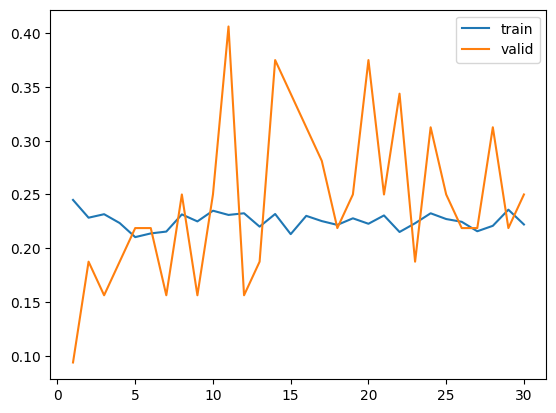

In [97]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

Pruebo con otro modelo

In [131]:
import torch.nn as nn
from torchinfo import summary

class Model3(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size + 1 para padding o UNK
        # embedding_dim = 50 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding_dim = 50
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=256) # Fully connected layer
        self.fc3 = nn.Linear(in_features=256, out_features=512) # Fully connected layer
        self.fc4 = nn.Linear(in_features=512, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.sigmoid(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out_f2 = self.sigmoid(self.fc2(out))
        out = self.dropout(out_f2)
        out_f3 = self.sigmoid(self.fc3(out))
        out = self.dropout(out_f3)
        out = self.softmax(self.fc4(out))
        return out

In [140]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = joined_df['Review Text'].values
text_sequences.shape

corpus = ' '.join(text_sequences)

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)
minimized_X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
ohe = OneHotEncoder(sparse=False)
minimized_y = ohe.fit_transform(joined_df['Rating'].to_numpy().reshape(-1,1))

data_set_2 = Data(minimized_X, minimized_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(599)
data_set_2_reduced_size = int(data_set_2.len * 1)
valid_set_size = int(data_set_2_reduced_size * 0.1)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model3(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

input_size: 115
Output dim 3
Tamaño del conjunto de entrenamiento: 20377
Tamaño del conjunto de validacion: 2264


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/4166223135.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/

Layer (type:depth-idx)                   Output Shape              Param #
Model3                                   [1, 3]                    --
├─Embedding: 1-1                         [1, 115, 50]              100,050
├─LSTM: 1-2                              [1, 115, 64]              62,976
├─Linear: 1-3                            [1, 128]                  8,320
├─Sigmoid: 1-4                           [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 256]                  33,024
├─Sigmoid: 1-7                           [1, 256]                  --
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 512]                  131,584
├─Sigmoid: 1-10                          [1, 512]                  --
├─Dropout: 1-11                          [1, 512]                  --
├─Linear: 1-12                           [1, 3]                 

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/4166223135.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


Epoch: 1/30 - Train loss 0.715 - Train accuracy 0.555 - Valid Loss 0.660 - Valid accuracy 0.719
Epoch: 2/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.702 - Valid accuracy 0.594
Epoch: 3/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.723 - Valid accuracy 0.531
Epoch: 4/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.671 - Valid accuracy 0.688
Epoch: 5/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.702 - Valid accuracy 0.594
Epoch: 6/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.733 - Valid accuracy 0.500
Epoch: 7/30 - Train loss 0.715 - Train accuracy 0.555 - Valid Loss 0.723 - Valid accuracy 0.531
Epoch: 8/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.712 - Valid accuracy 0.562
Epoch: 9/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.702 - Valid accuracy 0.594
Epoch: 10/30 - Train loss 0.715 - Train accuracy 0.556 - Valid Loss 0.692 - Valid accuracy 0.625
Epoch: 11/30 - Train loss 0.715 - Train

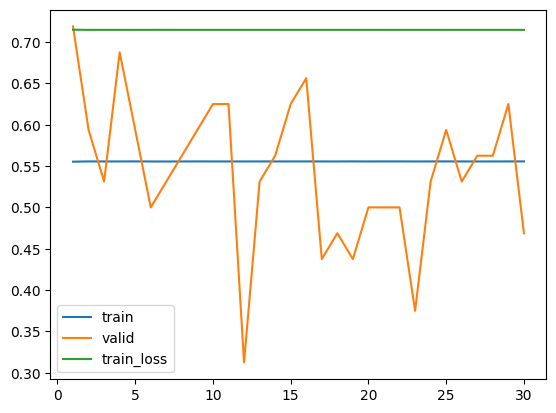

In [141]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train_loss')
plt.show()

In [143]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

corpus = ' '.join(text_sequences)

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)
minimized_X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
ohe = OneHotEncoder(sparse=False)
minimized_y = ohe.fit_transform(df_reviews['Rating'].to_numpy().reshape(-1,1))

data_set_2 = Data(minimized_X, minimized_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(147)
data_set_2_reduced_size = int(data_set_2.len * 1)
valid_set_size = int(data_set_2_reduced_size * 0.1)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model3(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

input_size: 115
Output dim 5
Tamaño del conjunto de entrenamiento: 20377
Tamaño del conjunto de validacion: 2264


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/4166223135.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/

Layer (type:depth-idx)                   Output Shape              Param #
Model3                                   [1, 5]                    --
├─Embedding: 1-1                         [1, 115, 50]              100,050
├─LSTM: 1-2                              [1, 115, 64]              62,976
├─Linear: 1-3                            [1, 128]                  8,320
├─Sigmoid: 1-4                           [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 256]                  33,024
├─Sigmoid: 1-7                           [1, 256]                  --
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 512]                  131,584
├─Sigmoid: 1-10                          [1, 512]                  --
├─Dropout: 1-11                          [1, 512]                  --
├─Linear: 1-12                           [1, 5]                 

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/4166223135.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


Epoch: 1/30 - Train loss 0.709 - Train accuracy 0.551 - Valid Loss 0.736 - Valid accuracy 0.406
Epoch: 2/30 - Train loss 0.706 - Train accuracy 0.554 - Valid Loss 0.748 - Valid accuracy 0.344
Epoch: 3/30 - Train loss 0.706 - Train accuracy 0.555 - Valid Loss 0.736 - Valid accuracy 0.406
Epoch: 4/30 - Train loss 0.706 - Train accuracy 0.555 - Valid Loss 0.705 - Valid accuracy 0.562
Epoch: 5/30 - Train loss 0.706 - Train accuracy 0.554 - Valid Loss 0.692 - Valid accuracy 0.625
Epoch: 6/30 - Train loss 0.706 - Train accuracy 0.555 - Valid Loss 0.673 - Valid accuracy 0.719
Epoch: 7/30 - Train loss 0.706 - Train accuracy 0.554 - Valid Loss 0.711 - Valid accuracy 0.531
Epoch: 8/30 - Train loss 0.706 - Train accuracy 0.554 - Valid Loss 0.698 - Valid accuracy 0.594
Epoch: 9/30 - Train loss 0.706 - Train accuracy 0.555 - Valid Loss 0.705 - Valid accuracy 0.562
Epoch: 10/30 - Train loss 0.706 - Train accuracy 0.554 - Valid Loss 0.717 - Valid accuracy 0.500
Epoch: 11/30 - Train loss 0.706 - Train

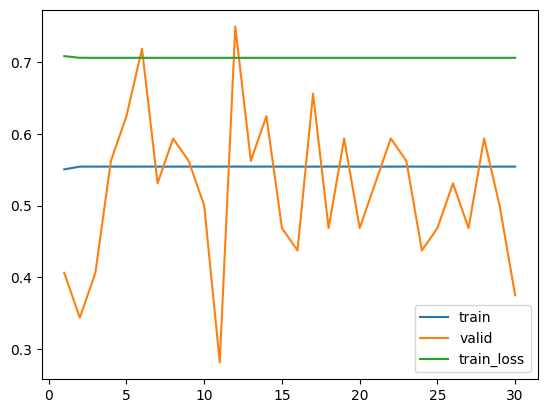

In [144]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train_loss')
plt.show()

Veo que train_loss no baja a medida que suben las epochs, por lo que pruebo otro modelo

In [145]:
import torch.nn as nn
from torchinfo import summary

class Model4(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size + 1 para padding o UNK
        # embedding_dim = 50 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding_dim = 50
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128) # Fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=256) # Fully connected layer
        self.fc4 = nn.Linear(in_features=256, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.sigmoid(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out_f2 = self.sigmoid(self.fc2(out))
        out = self.dropout(out_f2)
        out = self.softmax(self.fc4(out))
        return out

In [149]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = minimized_df['Review Text'].values
text_sequences.shape

corpus = ' '.join(text_sequences)

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)

num_words = 4000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)
minimized_X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
ohe = OneHotEncoder(sparse=False)
minimized_y = ohe.fit_transform(minimized_df['Rating'].to_numpy().reshape(-1,1))

data_set_2 = Data(minimized_X, minimized_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(912)
data_set_2_reduced_size = int(data_set_2.len * 1)
valid_set_size = int(data_set_2_reduced_size * 0.1)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model4(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

input_size: 115
Output dim 5
Tamaño del conjunto de entrenamiento: 9756
Tamaño del conjunto de validacion: 1083


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/

Layer (type:depth-idx)                   Output Shape              Param #
Model4                                   [1, 5]                    --
├─Embedding: 1-1                         [1, 115, 50]              200,050
├─LSTM: 1-2                              [1, 115, 64]              62,976
├─Linear: 1-3                            [1, 128]                  8,320
├─Sigmoid: 1-4                           [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 256]                  33,024
├─Sigmoid: 1-7                           [1, 256]                  --
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 5]                    1,285
├─Softmax: 1-10                          [1, 5]                    --
Total params: 305,655
Trainable params: 305,655
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.48
Input size (MB): 0.00
Fo

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


Epoch: 1/500 - Train loss 0.746 - Train accuracy 0.316 - Valid Loss 0.754 - Valid accuracy 0.250
Epoch: 2/500 - Train loss 0.734 - Train accuracy 0.399 - Valid Loss 0.729 - Valid accuracy 0.406
Epoch: 3/500 - Train loss 0.730 - Train accuracy 0.426 - Valid Loss 0.712 - Valid accuracy 0.469
Epoch: 4/500 - Train loss 0.726 - Train accuracy 0.447 - Valid Loss 0.750 - Valid accuracy 0.312
Epoch: 5/500 - Train loss 0.731 - Train accuracy 0.414 - Valid Loss 0.697 - Valid accuracy 0.594
Epoch: 6/500 - Train loss 0.725 - Train accuracy 0.451 - Valid Loss 0.730 - Valid accuracy 0.438
Epoch: 7/500 - Train loss 0.719 - Train accuracy 0.483 - Valid Loss 0.729 - Valid accuracy 0.438
Epoch: 8/500 - Train loss 0.716 - Train accuracy 0.497 - Valid Loss 0.708 - Valid accuracy 0.531
Epoch: 9/500 - Train loss 0.713 - Train accuracy 0.520 - Valid Loss 0.707 - Valid accuracy 0.531
Epoch: 10/500 - Train loss 0.710 - Train accuracy 0.536 - Valid Loss 0.729 - Valid accuracy 0.438
Epoch: 11/500 - Train loss 0.

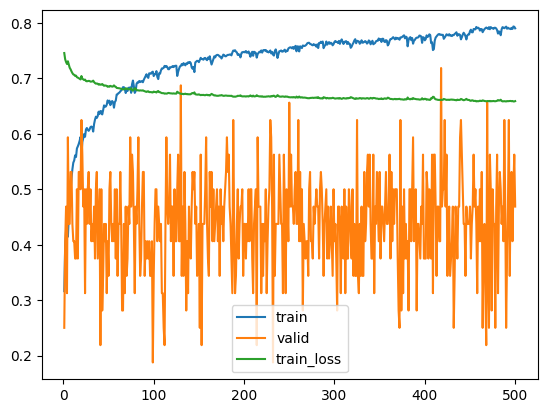

In [150]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=500
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train_loss')
plt.show()

Ahora se ve una evolución del acc a medida que suben las epochs

Intentamos otro preprocesamiento

La idea es tomar ejemplos de las clases minoritarias e intentar en función de los mismos crear ejemplos similares, aplicando el concepto de data augmentation. Para agregar n ejemplos a una clase, tomaremos ejemplos reales y les cambiaremos palabras que tienen connotacion negativa por otras palabras con connotación negativa tomadas de la clase de la que queremos crear ejemplos, tomando alguna aleatoria de entre las palabras mas usadas.

In [151]:
df_reviews['Rating'].value_counts()

Rating
4    12540
3     4908
2     2823
1     1549
0      821
Name: count, dtype: int64

In [152]:
class_0 = df_reviews[df_reviews['Rating'] == 0]
class_0['Rating'].value_counts()

Rating
0    821
Name: count, dtype: int64

In [161]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ezequielfernandez/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [162]:
class_0_sequences = class_0['Review Text'].values
# Concatenar todas las reviews para armar el corpus
class_0_corpus = ' '.join(class_0_sequences)
class_0_tokens = text_to_word_sequence(class_0_corpus)

In [167]:
class_0_tokens[:10]

['3', 'tags', 'sewn', 'in', '2', 'small', 'about', "1''", 'long', 'and']

In [175]:
import re
pattern = r'[^a-zA-z.,!?/:;\'\s]' # igual al anterior pero sin cifras numéricas

Esta es una lista de palabras con connotación negativa tomada de internet. Link: https://ptrckprry.com/course/ssd/data/negative-words.txt


In [194]:
negative_words = ["abnormal","abolish","abominable","abominably","abominate","abomination","abort","aborted","aborts","abrade","abrasive","abrupt","abruptly","abscond","absence","absent-minded","absentee","absurd","absurdity","absurdly","absurdness","abuse","abused","abuses","abusive","abysmal","abysmally","abyss","accidental","accost","accursed","accusation","accusations","accuse","accuses","accusing","accusingly","acerbate","acerbic","acerbically","ache","ached","aches","achey","aching","acrid","acridly","acridness","acrimonious","acrimoniously","acrimony","adamant","adamantly","addict","addicted","addicting","addicts","admonish","admonisher","admonishingly","admonishment","admonition","adulterate","adulterated","adulteration","adulterier","adversarial","adversary","adverse","adversity","afflict","affliction","afflictive","affront","afraid","aggravate","aggravating","aggravation","aggression","aggressive","aggressiveness","aggressor","aggrieve","aggrieved","aggrivation","aghast","agonies","agonize","agonizing","agonizingly","agony","aground","ail","ailing","ailment","aimless","alarm","alarmed","alarming","alarmingly","alienate","alienated","alienation","allegation","allegations","allege","allergic","allergies","allergy","aloof","altercation","ambiguity","ambiguous","ambivalence","ambivalent","ambush","amiss","amputate","anarchism","anarchist","anarchistic","anarchy","anemic","anger","angrily","angriness","angry","anguish","animosity","annihilate","annihilation","annoy","annoyance","annoyances","annoyed","annoying","annoyingly","annoys","anomalous","anomaly","antagonism","antagonist","antagonistic","antagonize","anti-","anti-american","anti-israeli","anti-occupation","anti-proliferation","anti-semites","anti-social","anti-us","anti-white","antipathy","antiquated","antithetical","anxieties","anxiety","anxious","anxiously","anxiousness","apathetic","apathetically","apathy","apocalypse","apocalyptic","apologist","apologists","appal","appall","appalled","appalling","appallingly","apprehension","apprehensions","apprehensive","apprehensively","arbitrary","arcane","archaic","arduous","arduously","argumentative","arrogance","arrogant","arrogantly","ashamed","asinine","asininely","asinininity","askance","asperse","aspersion","aspersions","assail","assassin","assassinate","assault","assult","astray","asunder","atrocious","atrocities","atrocity","atrophy","attack","attacks","audacious","audaciously","audaciousness","audacity","audiciously","austere","authoritarian","autocrat","autocratic","avalanche","avarice","avaricious","avariciously","avenge","averse","aversion","aweful","awful","awfully","awfulness","awkward","awkwardness","ax","babble","back-logged","back-wood","back-woods","backache","backaches","backaching","backbite","backbiting","backward","backwardness","backwood","backwoods","bad","badly","baffle","baffled","bafflement","baffling","bait","balk","banal","banalize","bane","banish","banishment","bankrupt","barbarian","barbaric","barbarically","barbarity","barbarous","barbarously","barren","baseless","bash","bashed","bashful","bashing","bastard","bastards","battered","battering","batty","bearish","beastly","bedlam","bedlamite","befoul","beg","beggar","beggarly","begging","beguile","belabor","belated","beleaguer","belie","belittle","belittled","belittling","bellicose","belligerence","belligerent","belligerently","bemoan","bemoaning","bemused","bent","berate","bereave","bereavement","bereft","berserk","beseech","beset","besiege","besmirch","bestial","betray","betrayal","betrayals","betrayer","betraying","betrays","bewail","beware","bewilder","bewildered","bewildering","bewilderingly","bewilderment","bewitch","bias","biased","biases","bicker","bickering","bid-rigging","bigotries","bigotry","bitch","bitchy","biting","bitingly","bitter","bitterly","bitterness","bizarre","blab","blabber","blackmail","blah","blame","blameworthy","bland","blandish","blaspheme","blasphemous","blasphemy","blasted","blatant","blatantly","blather","bleak","bleakly","bleakness","bleed","bleeding","bleeds","blemish","blind","blinding","blindingly","blindside","blister","blistering","bloated","blockage","blockhead","bloodshed","bloodthirsty","bloody","blotchy","blow","blunder","blundering","blunders","blunt","blur","bluring","blurred","blurring","blurry","blurs","blurt","boastful","boggle","bogus","boil","boiling","boisterous","bomb","bombard","bombardment","bombastic","bondage","bonkers","bore","bored","boredom","bores","boring","botch","bother","bothered","bothering","bothers","bothersome","bowdlerize","boycott","braggart","bragger","brainless","brainwash","brash","brashly","brashness","brat","bravado","brazen","brazenly","brazenness","breach","break","break-up","break-ups","breakdown","breaking","breaks","breakup","breakups","bribery","brimstone","bristle","brittle","broke","broken","broken-hearted","brood","browbeat","bruise","bruised","bruises","bruising","brusque","brutal","brutalising","brutalities","brutality","brutalize","brutalizing","brutally","brute","brutish","bs","buckle","bug","bugging","buggy","bugs","bulkier","bulkiness","bulky","bulkyness","bull****","bull----","bullies","bullshit","bullshyt","bully","bullying","bullyingly","bum","bump","bumped","bumping","bumpping","bumps","bumpy","bungle","bungler","bungling","bunk","burden","burdensome","burdensomely","burn","burned","burning","burns","bust","busts","busybody","butcher","butchery","buzzing","byzantine","cackle","calamities","calamitous","calamitously","calamity","callous","calumniate","calumniation","calumnies","calumnious","calumniously","calumny","cancer","cancerous","cannibal","cannibalize","capitulate","capricious","capriciously","capriciousness","capsize","careless","carelessness","caricature","carnage","carp","cartoonish","cash-strapped","castigate","castrated","casualty","cataclysm","cataclysmal","cataclysmic","cataclysmically","catastrophe","catastrophes","catastrophic","catastrophically","catastrophies","caustic","caustically","cautionary","cave","censure","chafe","chaff","chagrin","challenging","chaos","chaotic","chasten","chastise","chastisement","chatter","chatterbox","cheap","cheapen","cheaply","cheat","cheated","cheater","cheating","cheats","checkered","cheerless","cheesy","chide","childish","chill","chilly","chintzy","choke","choleric","choppy","chore","chronic","chunky","clamor","clamorous","clash","cliche","cliched","clique","clog","clogged","clogs","cloud","clouding","cloudy","clueless","clumsy","clunky","coarse","cocky","coerce","coercion","coercive","cold","coldly","collapse","collude","collusion","combative","combust","comical","commiserate","commonplace","commotion","commotions","complacent","complain","complained","complaining","complains","complaint","complaints","complex","complicated","complication","complicit","compulsion","compulsive","concede","conceded","conceit","conceited","concen","concens","concern","concerned","concerns","concession","concessions","condemn","condemnable","condemnation","condemned","condemns","condescend","condescending","condescendingly","condescension","confess","confession","confessions","confined","conflict","conflicted","conflicting","conflicts","confound","confounded","confounding","confront","confrontation","confrontational","confuse","confused","confuses","confusing","confusion","confusions","congested","congestion","cons","conscons","conservative","conspicuous","conspicuously","conspiracies","conspiracy","conspirator","conspiratorial","conspire","consternation","contagious","contaminate","contaminated","contaminates","contaminating","contamination","contempt","contemptible","contemptuous","contemptuously","contend","contention","contentious","contort","contortions","contradict","contradiction","contradictory","contrariness","contravene","contrive","contrived","controversial","controversy","convoluted","corrode","corrosion","corrosions","corrosive","corrupt","corrupted","corrupting","corruption","corrupts","corruptted","costlier","costly","counter-productive","counterproductive","coupists","covetous","coward","cowardly","crabby","crack","cracked","cracks","craftily","craftly","crafty","cramp","cramped","cramping","cranky","crap","crappy","craps","crash","crashed","crashes","crashing","crass","craven","cravenly","craze","crazily","craziness","crazy","creak","creaking","creaks","credulous","creep","creeping","creeps","creepy","crept","crime","criminal","cringe","cringed","cringes","cripple","crippled","cripples","crippling","crisis","critic","critical","criticism","criticisms","criticize","criticized","criticizing","critics","cronyism","crook","crooked","crooks","crowded","crowdedness","crude","cruel","crueler","cruelest","cruelly","cruelness","cruelties","cruelty","crumble","crumbling","crummy","crumple","crumpled","crumples","crush","crushed","crushing","cry","culpable","culprit","cumbersome","cunt","cunts","cuplrit","curse","cursed","curses","curt","cuss","cussed","cutthroat","cynical","cynicism","d*mn","damage","damaged","damages","damaging","damn","damnable","damnably","damnation","damned","damning","damper","danger","dangerous","dangerousness","dark","darken","darkened","darker","darkness","dastard","dastardly","daunt","daunting","dauntingly","dawdle","daze","dazed","dead","deadbeat","deadlock","deadly","deadweight","deaf","dearth","death","debacle","debase","debasement","debaser","debatable","debauch","debaucher","debauchery","debilitate","debilitating","debility","debt","debts","decadence","decadent","decay","decayed","deceit","deceitful","deceitfully","deceitfulness","deceive","deceiver","deceivers","deceiving","deception","deceptive","deceptively","declaim","decline","declines","declining","decrement","decrepit","decrepitude","decry","defamation","defamations","defamatory","defame","defect","defective","defects","defensive","defiance","defiant","defiantly","deficiencies","deficiency","deficient","defile","defiler","deform","deformed","defrauding","defunct","defy","degenerate","degenerately","degeneration","degradation","degrade","degrading","degradingly","dehumanization","dehumanize","deign","deject","dejected","dejectedly","dejection","delay","delayed","delaying","delays","delinquency","delinquent","delirious","delirium","delude","deluded","deluge","delusion","delusional","delusions","demean","demeaning","demise","demolish","demolisher","demon","demonic","demonize","demonized","demonizes","demonizing","demoralize","demoralizing","demoralizingly","denial","denied","denies","denigrate","denounce","dense","dent","dented","dents","denunciate","denunciation","denunciations","deny","denying","deplete","deplorable","deplorably","deplore","deploring","deploringly","deprave","depraved","depravedly","deprecate","depress","depressed","depressing","depressingly","depression","depressions","deprive","deprived","deride","derision","derisive","derisively","derisiveness","derogatory","desecrate","desert","desertion","desiccate","desiccated","desititute","desolate","desolately","desolation","despair","despairing","despairingly","desperate","desperately","desperation","despicable","despicably","despise","despised","despoil","despoiler","despondence","despondency","despondent","despondently","despot","despotic","despotism","destabilisation","destains","destitute","destitution","destroy","destroyer","destruction","destructive","desultory","deter","deteriorate","deteriorating","deterioration","deterrent","detest","detestable","detestably","detested","detesting","detests","detract","detracted","detracting","detraction","detracts","detriment","detrimental","devastate","devastated","devastates","devastating","devastatingly","devastation","deviate","deviation","devil","devilish","devilishly","devilment","devilry","devious","deviously","deviousness","devoid","diabolic","diabolical","diabolically","diametrically","diappointed","diatribe","diatribes","dick","dictator","dictatorial","die","die-hard","died","dies","difficult","difficulties","difficulty","diffidence","dilapidated","dilemma","dilly-dally","dim","dimmer","din","ding","dings","dinky","dire","direly","direness","dirt","dirtbag","dirtbags","dirts","dirty","disable","disabled","disaccord","disadvantage","disadvantaged","disadvantageous","disadvantages","disaffect","disaffected","disaffirm","disagree","disagreeable","disagreeably","disagreed","disagreeing","disagreement","disagrees","disallow","disapointed","disapointing","disapointment","disappoint","disappointed","disappointing","disappointingly","disappointment","disappointments","disappoints","disapprobation","disapproval","disapprove","disapproving","disarm","disarray","disaster","disasterous","disastrous","disastrously","disavow","disavowal","disbelief","disbelieve","disbeliever","disclaim","discombobulate","discomfit","discomfititure","discomfort","discompose","disconcert","disconcerted","disconcerting","disconcertingly","disconsolate","disconsolately","disconsolation","discontent","discontented","discontentedly","discontinued","discontinuity","discontinuous","discord","discordance","discordant","discountenance","discourage","discouragement","discouraging","discouragingly","discourteous","discourteously","discoutinous","discredit","discrepant","discriminate","discrimination","discriminatory","disdain","disdained","disdainful","disdainfully","disfavor","disgrace","disgraced","disgraceful","disgracefully","disgruntle","disgruntled","disgust","disgusted","disgustedly","disgustful","disgustfully","disgusting","disgustingly","dishearten","disheartening","dishearteningly","dishonest","dishonestly","dishonesty","dishonor","dishonorable","dishonorablely","disillusion","disillusioned","disillusionment","disillusions","disinclination","disinclined","disingenuous","disingenuously","disintegrate","disintegrated","disintegrates","disintegration","disinterest","disinterested","dislike","disliked","dislikes","disliking","dislocated","disloyal","disloyalty","dismal","dismally","dismalness","dismay","dismayed","dismaying","dismayingly","dismissive","dismissively","disobedience","disobedient","disobey","disoobedient","disorder","disordered","disorderly","disorganized","disorient","disoriented","disown","disparage","disparaging","disparagingly","dispensable","dispirit","dispirited","dispiritedly","dispiriting","displace","displaced","displease","displeased","displeasing","displeasure","disproportionate","disprove","disputable","dispute","disputed","disquiet","disquieting","disquietingly","disquietude","disregard","disregardful","disreputable","disrepute","disrespect","disrespectable","disrespectablity","disrespectful","disrespectfully","disrespectfulness","disrespecting","disrupt","disruption","disruptive","diss","dissapointed","dissappointed","dissappointing","dissatisfaction","dissatisfactory","dissatisfied","dissatisfies","dissatisfy","dissatisfying","dissed","dissemble","dissembler","dissension","dissent","dissenter","dissention","disservice","disses","dissidence","dissident","dissidents","dissing","dissocial","dissolute","dissolution","dissonance","dissonant","dissonantly","dissuade","dissuasive","distains","distaste","distasteful","distastefully","distort","distorted","distortion","distorts","distract","distracting","distraction","distraught","distraughtly","distraughtness","distress","distressed","distressing","distressingly","distrust","distrustful","distrusting","disturb","disturbance","disturbed","disturbing","disturbingly","disunity","disvalue","divergent","divisive","divisively","divisiveness","dizzing","dizzingly","dizzy","doddering","dodgey","dogged","doggedly","dogmatic","doldrums","domineer","domineering","donside","doom","doomed","doomsday","dope","doubt","doubtful","doubtfully","doubts","douchbag","douchebag","douchebags","downbeat","downcast","downer","downfall","downfallen","downgrade","downhearted","downheartedly","downhill","downside","downsides","downturn","downturns","drab","draconian","draconic","drag","dragged","dragging","dragoon","drags","drain","drained","draining","drains","drastic","drastically","drawback","drawbacks","dread","dreadful","dreadfully","dreadfulness","dreary","dripped","dripping","drippy","drips","drones","droop","droops","drop-out","drop-outs","dropout","dropouts","drought","drowning","drunk","drunkard","drunken","dubious","dubiously","dubitable","dud","dull","dullard","dumb","dumbfound","dump","dumped","dumping","dumps","dunce","dungeon","dungeons","dupe","dust","dusty","dwindling","dying","earsplitting","eccentric","eccentricity","effigy","effrontery","egocentric","egomania","egotism","egotistical","egotistically","egregious","egregiously","election-rigger","elimination","emaciated","emasculate","embarrass","embarrassing","embarrassingly","embarrassment","embattled","embroil","embroiled","embroilment","emergency","emphatic","emphatically","emptiness","encroach","encroachment","endanger","enemies","enemy","enervate","enfeeble","enflame","engulf","enjoin","enmity","enrage","enraged","enraging","enslave","entangle","entanglement","entrap","entrapment","envious","enviously","enviousness","epidemic","equivocal","erase","erode","erodes","erosion","err","errant","erratic","erratically","erroneous","erroneously","error","errors","eruptions","escapade","eschew","estranged","evade","evasion","evasive","evil","evildoer","evils","eviscerate","exacerbate","exagerate","exagerated","exagerates","exaggerate","exaggeration","exasperate","exasperated","exasperating","exasperatingly","exasperation","excessive","excessively","exclusion","excoriate","excruciating","excruciatingly","excuse","excuses","execrate","exhaust","exhausted","exhaustion","exhausts","exhorbitant","exhort","exile","exorbitant","exorbitantance","exorbitantly","expel","expensive","expire","expired","explode","exploit","exploitation","explosive","expropriate","expropriation","expulse","expunge","exterminate","extermination","extinguish","extort","extortion","extraneous","extravagance","extravagant","extravagantly","extremism","extremist","extremists","eyesore","f**k","fabricate","fabrication","facetious","facetiously","fail","failed","failing","fails","failure","failures","faint","fainthearted","faithless","fake","fall","fallacies","fallacious","fallaciously","fallaciousness","fallacy","fallen","falling","fallout","falls","false","falsehood","falsely","falsify","falter","faltered","famine","famished","fanatic","fanatical","fanatically","fanaticism","fanatics","fanciful","far-fetched","farce","farcical","farcical-yet-provocative","farcically","farfetched","fascism","fascist","fastidious","fastidiously","fastuous","fat","fat-cat","fat-cats","fatal","fatalistic","fatalistically","fatally","fatcat","fatcats","fateful","fatefully","fathomless","fatigue","fatigued","fatique","fatty","fatuity","fatuous","fatuously","fault","faults","faulty","fawningly","faze","fear","fearful","fearfully","fears","fearsome","feckless","feeble","feeblely","feebleminded","feign","feint","fell","felon","felonious","ferociously","ferocity","fetid","fever","feverish","fevers","fiasco","fib","fibber","fickle","fiction","fictional","fictitious","fidget","fidgety","fiend","fiendish","fierce","figurehead","filth","filthy","finagle","finicky","fissures","fist","flabbergast","flabbergasted","flagging","flagrant","flagrantly","flair","flairs","flak","flake","flakey","flakieness","flaking","flaky","flare","flares","flareup","flareups","flat-out","flaunt","flaw","flawed","flaws","flee","fleed","fleeing","fleer","flees","fleeting","flicering","flicker","flickering","flickers","flighty","flimflam","flimsy","flirt","flirty","floored","flounder","floundering","flout","fluster","foe","fool","fooled","foolhardy","foolish","foolishly","foolishness","forbid","forbidden","forbidding","forceful","foreboding","forebodingly","forfeit","forged","forgetful","forgetfully","forgetfulness","forlorn","forlornly","forsake","forsaken","forswear","foul","foully","foulness","fractious","fractiously","fracture","fragile","fragmented","frail","frantic","frantically","franticly","fraud","fraudulent","fraught","frazzle","frazzled","freak","freaking","freakish","freakishly","freaks","freeze","freezes","freezing","frenetic","frenetically","frenzied","frenzy","fret","fretful","frets","friction","frictions","fried","friggin","frigging","fright","frighten","frightening","frighteningly","frightful","frightfully","frigid","frost","frown","froze","frozen","fruitless","fruitlessly","frustrate","frustrated","frustrates","frustrating","frustratingly","frustration","frustrations","fuck","fucking","fudge","fugitive","full-blown","fulminate","fumble","fume","fumes","fundamentalism","funky","funnily","funny","furious","furiously","furor","fury","fuss","fussy","fustigate","fusty","futile","futilely","futility","fuzzy","gabble","gaff","gaffe","gainsay","gainsayer","gall","galling","gallingly","galls","gangster","gape","garbage","garish","gasp","gauche","gaudy","gawk","gawky","geezer","genocide","get-rich","ghastly","ghetto","ghosting","gibber","gibberish","gibe","giddy","gimmick","gimmicked","gimmicking","gimmicks","gimmicky","glare","glaringly","glib","glibly","glitch","glitches","gloatingly","gloom","gloomy","glower","glum","glut","gnawing","goad","goading","god-awful","goof","goofy","goon","gossip","graceless","gracelessly","graft","grainy","grapple","grate","grating","gravely","greasy","greed","greedy","grief","grievance","grievances","grieve","grieving","grievous","grievously","grim","grimace","grind","gripe","gripes","grisly","gritty","gross","grossly","grotesque","grouch","grouchy","groundless","grouse","growl","grudge","grudges","grudging","grudgingly","gruesome","gruesomely","gruff","grumble","grumpier","grumpiest","grumpily","grumpish","grumpy","guile","guilt","guiltily","guilty","gullible","gutless","gutter","hack","hacks","haggard","haggle","hairloss","halfhearted","halfheartedly","hallucinate","hallucination","hamper","hampered","handicapped","hang","hangs","haphazard","hapless","harangue","harass","harassed","harasses","harassment","harboring","harbors","hard","hard-hit","hard-line","hard-liner","hardball","harden","hardened","hardheaded","hardhearted","hardliner","hardliners","hardship","hardships","harm","harmed","harmful","harms","harpy","harridan","harried","harrow","harsh","harshly","hasseling","hassle","hassled","hassles","haste","hastily","hasty","hate","hated","hateful","hatefully","hatefulness","hater","haters","hates","hating","hatred","haughtily","haughty","haunt","haunting","havoc","hawkish","haywire","hazard","hazardous","haze","hazy","head-aches","headache","headaches","heartbreaker","heartbreaking","heartbreakingly","heartless","heathen","heavy-handed","heavyhearted","heck","heckle","heckled","heckles","hectic","hedge","hedonistic","heedless","hefty","hegemonism","hegemonistic","hegemony","heinous","hell","hell-bent","hellion","hells","helpless","helplessly","helplessness","heresy","heretic","heretical","hesitant","hestitant","hideous","hideously","hideousness","high-priced","hiliarious","hinder","hindrance","hiss","hissed","hissing","ho-hum","hoard","hoax","hobble","hogs","hollow","hoodium","hoodwink","hooligan","hopeless","hopelessly","hopelessness","horde","horrendous","horrendously","horrible","horrid","horrific","horrified","horrifies","horrify","horrifying","horrifys","hostage","hostile","hostilities","hostility","hotbeds","hothead","hotheaded","hothouse","hubris","huckster","hum","humid","humiliate","humiliating","humiliation","humming","hung","hurt","hurted","hurtful","hurting","hurts","hustler","hype","hypocricy","hypocrisy","hypocrite","hypocrites","hypocritical","hypocritically","hysteria","hysteric","hysterical","hysterically","hysterics","idiocies","idiocy","idiot","idiotic","idiotically","idiots","idle","ignoble","ignominious","ignominiously","ignominy","ignorance","ignorant","ignore","ill-advised","ill-conceived","ill-defined","ill-designed","ill-fated","ill-favored","ill-formed","ill-mannered","ill-natured","ill-sorted","ill-tempered","ill-treated","ill-treatment","ill-usage","ill-used","illegal","illegally","illegitimate","illicit","illiterate","illness","illogic","illogical","illogically","illusion","illusions","illusory","imaginary","imbalance","imbecile","imbroglio","immaterial","immature","imminence","imminently","immobilized","immoderate","immoderately","immodest","immoral","immorality","immorally","immovable","impair","impaired","impasse","impatience","impatient","impatiently","impeach","impedance","impede","impediment","impending","impenitent","imperfect","imperfection","imperfections","imperfectly","imperialist","imperil","imperious","imperiously","impermissible","impersonal","impertinent","impetuous","impetuously","impiety","impinge","impious","implacable","implausible","implausibly","implicate","implication","implode","impolite","impolitely","impolitic","importunate","importune","impose","imposers","imposing","imposition","impossible","impossiblity","impossibly","impotent","impoverish","impoverished","impractical","imprecate","imprecise","imprecisely","imprecision","imprison","imprisonment","improbability","improbable","improbably","improper","improperly","impropriety","imprudence","imprudent","impudence","impudent","impudently","impugn","impulsive","impulsively","impunity","impure","impurity","inability","inaccuracies","inaccuracy","inaccurate","inaccurately","inaction","inactive","inadequacy","inadequate","inadequately","inadverent","inadverently","inadvisable","inadvisably","inane","inanely","inappropriate","inappropriately","inapt","inaptitude","inarticulate","inattentive","inaudible","incapable","incapably","incautious","incendiary","incense","incessant","incessantly","incite","incitement","incivility","inclement","incognizant","incoherence","incoherent","incoherently","incommensurate","incomparable","incomparably","incompatability","incompatibility","incompatible","incompetence","incompetent","incompetently","incomplete","incompliant","incomprehensible","incomprehension","inconceivable","inconceivably","incongruous","incongruously","inconsequent","inconsequential","inconsequentially","inconsequently","inconsiderate","inconsiderately","inconsistence","inconsistencies","inconsistency","inconsistent","inconsolable","inconsolably","inconstant","inconvenience","inconveniently","incorrect","incorrectly","incorrigible","incorrigibly","incredulous","incredulously","inculcate","indecency","indecent","indecently","indecision","indecisive","indecisively","indecorum","indefensible","indelicate","indeterminable","indeterminably","indeterminate","indifference","indifferent","indigent","indignant","indignantly","indignation","indignity","indiscernible","indiscreet","indiscreetly","indiscretion","indiscriminate","indiscriminately","indiscriminating","indistinguishable","indoctrinate","indoctrination","indolent","indulge","ineffective","ineffectively","ineffectiveness","ineffectual","ineffectually","ineffectualness","inefficacious","inefficacy","inefficiency","inefficient","inefficiently","inelegance","inelegant","ineligible","ineloquent","ineloquently","inept","ineptitude","ineptly","inequalities","inequality","inequitable","inequitably","inequities","inescapable","inescapably","inessential","inevitable","inevitably","inexcusable","inexcusably","inexorable","inexorably","inexperience","inexperienced","inexpert","inexpertly","inexpiable","inexplainable","inextricable","inextricably","infamous","infamously","infamy","infected","infection","infections","inferior","inferiority","infernal","infest","infested","infidel","infidels","infiltrator","infiltrators","infirm","inflame","inflammation","inflammatory","inflammed","inflated","inflationary","inflexible","inflict","infraction","infringe","infringement","infringements","infuriate","infuriated","infuriating","infuriatingly","inglorious","ingrate","ingratitude","inhibit","inhibition","inhospitable","inhospitality","inhuman","inhumane","inhumanity","inimical","inimically","iniquitous","iniquity","injudicious","injure","injurious","injury","injustice","injustices","innuendo","inoperable","inopportune","inordinate","inordinately","insane","insanely","insanity","insatiable","insecure","insecurity","insensible","insensitive","insensitively","insensitivity","insidious","insidiously","insignificance","insignificant","insignificantly","insincere","insincerely","insincerity","insinuate","insinuating","insinuation","insociable","insolence","insolent","insolently","insolvent","insouciance","instability","instable","instigate","instigator","instigators","insubordinate","insubstantial","insubstantially","insufferable","insufferably","insufficiency","insufficient","insufficiently","insular","insult","insulted","insulting","insultingly","insults","insupportable","insupportably","insurmountable","insurmountably","insurrection","intefere","inteferes","intense","interfere","interference","interferes","intermittent","interrupt","interruption","interruptions","intimidate","intimidating","intimidatingly","intimidation","intolerable","intolerablely","intolerance","intoxicate","intractable","intransigence","intransigent","intrude","intrusion","intrusive","inundate","inundated","invader","invalid","invalidate","invalidity","invasive","invective","inveigle","invidious","invidiously","invidiousness","invisible","involuntarily","involuntary","irascible","irate","irately","ire","irk","irked","irking","irks","irksome","irksomely","irksomeness","irksomenesses","ironic","ironical","ironically","ironies","irony","irragularity","irrational","irrationalities","irrationality","irrationally","irrationals","irreconcilable","irrecoverable","irrecoverableness","irrecoverablenesses","irrecoverably","irredeemable","irredeemably","irreformable","irregular","irregularity","irrelevance","irrelevant","irreparable","irreplacible","irrepressible","irresolute","irresolvable","irresponsible","irresponsibly","irretating","irretrievable","irreversible","irritable","irritably","irritant","irritate","irritated","irritating","irritation","irritations","isolate","isolated","isolation","issue","issues","itch","itching","itchy","jabber","jaded","jagged","jam","jarring","jaundiced","jealous","jealously","jealousness","jealousy","jeer","jeering","jeeringly","jeers","jeopardize","jeopardy","jerk","jerky","jitter","jitters","jittery","job-killing","jobless","joke","joker","jolt","judder","juddering","judders","jumpy","junk","junky","junkyard","jutter","jutters","kaput","kill","killed","killer","killing","killjoy","kills","knave","knife","knock","knotted","kook","kooky","lack","lackadaisical","lacked","lackey","lackeys","lacking","lackluster","lacks","laconic","lag","lagged","lagging","laggy","lags","laid-off","lambast","lambaste","lame","lame-duck","lament","lamentable","lamentably","languid","languish","languor","languorous","languorously","lanky","lapse","lapsed","lapses","lascivious","last-ditch","latency","laughable","laughably","laughingstock","lawbreaker","lawbreaking","lawless","lawlessness","layoff","layoff-happy","lazy","leak","leakage","leakages","leaking","leaks","leaky","lech","lecher","lecherous","lechery","leech","leer","leery","left-leaning","lemon","lengthy","less-developed","lesser-known","letch","lethal","lethargic","lethargy","lewd","lewdly","lewdness","liability","liable","liar","liars","licentious","licentiously","licentiousness","lie","lied","lier","lies","life-threatening","lifeless","limit","limitation","limitations","limited","limits","limp","listless","litigious","little-known","livid","lividly","loath","loathe","loathing","loathly","loathsome","loathsomely","lone","loneliness","lonely","loner","lonesome","long-time","long-winded","longing","longingly","loophole","loopholes","loose","loot","lorn","lose","loser","losers","loses","losing","loss","losses","lost","loud","louder","lousy","loveless","lovelorn","low-rated","lowly","ludicrous","ludicrously","lugubrious","lukewarm","lull","lumpy","lunatic","lunaticism","lurch","lure","lurid","lurk","lurking","lying","macabre","mad","madden","maddening","maddeningly","madder","madly","madman","madness","maladjusted","maladjustment","malady","malaise","malcontent","malcontented","maledict","malevolence","malevolent","malevolently","malice","malicious","maliciously","maliciousness","malign","malignant","malodorous","maltreatment","mangle","mangled","mangles","mangling","mania","maniac","maniacal","manic","manipulate","manipulation","manipulative","manipulators","mar","marginal","marginally","martyrdom","martyrdom-seeking","mashed","massacre","massacres","matte","mawkish","mawkishly","mawkishness","meager","meaningless","meanness","measly","meddle","meddlesome","mediocre","mediocrity","melancholy","melodramatic","melodramatically","meltdown","menace","menacing","menacingly","mendacious","mendacity","menial","merciless","mercilessly","mess","messed","messes","messing","messy","midget","miff","militancy","mindless","mindlessly","mirage","mire","misalign","misaligned","misaligns","misapprehend","misbecome","misbecoming","misbegotten","misbehave","misbehavior","miscalculate","miscalculation","miscellaneous","mischief","mischievous","mischievously","misconception","misconceptions","miscreant","miscreants","misdirection","miser","miserable","miserableness","miserably","miseries","miserly","misery","misfit","misfortune","misgiving","misgivings","misguidance","misguide","misguided","mishandle","mishap","misinform","misinformed","misinterpret","misjudge","misjudgment","mislead","misleading","misleadingly","mislike","mismanage","mispronounce","mispronounced","mispronounces","misread","misreading","misrepresent","misrepresentation","miss","missed","misses","misstatement","mist","mistake","mistaken","mistakenly","mistakes","mistified","mistress","mistrust","mistrustful","mistrustfully","mists","misunderstand","misunderstanding","misunderstandings","misunderstood","misuse","moan","mobster","mock","mocked","mockeries","mockery","mocking","mockingly","mocks","molest","molestation","monotonous","monotony","monster","monstrosities","monstrosity","monstrous","monstrously","moody","moot","mope","morbid","morbidly","mordant","mordantly","moribund","moron","moronic","morons","mortification","mortified","mortify","mortifying","motionless","motley","mourn","mourner","mournful","mournfully","muddle","muddy","mudslinger","mudslinging","mulish","multi-polarization","mundane","murder","murderer","murderous","murderously","murky","muscle-flexing","mushy","musty","mysterious","mysteriously","mystery","mystify","myth","nag","nagging","naive","naively","narrower","nastily","nastiness","nasty","naughty","nauseate","nauseates","nauseating","nauseatingly","na�ve","nebulous","nebulously","needless","needlessly","needy","nefarious","nefariously","negate","negation","negative","negatives","negativity","neglect","neglected","negligence","negligent","nemesis","nepotism","nervous","nervously","nervousness","nettle","nettlesome","neurotic","neurotically","niggle","niggles","nightmare","nightmarish","nightmarishly","nitpick","nitpicking","noise","noises","noisier","noisy","non-confidence","nonexistent","nonresponsive","nonsense","nosey","notoriety","notorious","notoriously","noxious","nuisance","numb","obese","object","objection","objectionable","objections","oblique","obliterate","obliterated","oblivious","obnoxious","obnoxiously","obscene","obscenely","obscenity","obscure","obscured","obscures","obscurity","obsess","obsessive","obsessively","obsessiveness","obsolete","obstacle","obstinate","obstinately","obstruct","obstructed","obstructing","obstruction","obstructs","obtrusive","obtuse","occlude","occluded","occludes","occluding","odd","odder","oddest","oddities","oddity","oddly","odor","offence","offend","offender","offending","offenses","offensive","offensively","offensiveness","officious","ominous","ominously","omission","omit","one-sided","onerous","onerously","onslaught","opinionated","opponent","opportunistic","oppose","opposition","oppositions","oppress","oppression","oppressive","oppressively","oppressiveness","oppressors","ordeal","orphan","ostracize","outbreak","outburst","outbursts","outcast","outcry","outlaw","outmoded","outrage","outraged","outrageous","outrageously","outrageousness","outrages","outsider","over-acted","over-awe","over-balanced","over-hyped","over-priced","over-valuation","overact","overacted","overawe","overbalance","overbalanced","overbearing","overbearingly","overblown","overdo","overdone","overdue","overemphasize","overheat","overkill","overloaded","overlook","overpaid","overpayed","overplay","overpower","overpriced","overrated","overreach","overrun","overshadow","oversight","oversights","oversimplification","oversimplified","oversimplify","oversize","overstate","overstated","overstatement","overstatements","overstates","overtaxed","overthrow","overthrows","overturn","overweight","overwhelm","overwhelmed","overwhelming","overwhelmingly","overwhelms","overzealous","overzealously","overzelous","pain","painful","painfull","painfully","pains","pale","pales","paltry","pan","pandemonium","pander","pandering","panders","panic","panick","panicked","panicking","panicky","paradoxical","paradoxically","paralize","paralyzed","paranoia","paranoid","parasite","pariah","parody","partiality","partisan","partisans","passe","passive","passiveness","pathetic","pathetically","patronize","paucity","pauper","paupers","payback","peculiar","peculiarly","pedantic","peeled","peeve","peeved","peevish","peevishly","penalize","penalty","perfidious","perfidity","perfunctory","peril","perilous","perilously","perish","pernicious","perplex","perplexed","perplexing","perplexity","persecute","persecution","pertinacious","pertinaciously","pertinacity","perturb","perturbed","pervasive","perverse","perversely","perversion","perversity","pervert","perverted","perverts","pessimism","pessimistic","pessimistically","pest","pestilent","petrified","petrify","pettifog","petty","phobia","phobic","phony","picket","picketed","picketing","pickets","picky","pig","pigs","pillage","pillory","pimple","pinch","pique","pitiable","pitiful","pitifully","pitiless","pitilessly","pittance","pity","plagiarize","plague","plasticky","plaything","plea","pleas","plebeian","plight","plot","plotters","ploy","plunder","plunderer","pointless","pointlessly","poison","poisonous","poisonously","pokey","poky","polarisation","polemize","pollute","polluter","polluters","polution","pompous","poor","poorer","poorest","poorly","posturing","pout","poverty","powerless","prate","pratfall","prattle","precarious","precariously","precipitate","precipitous","predatory","predicament","prejudge","prejudice","prejudices","prejudicial","premeditated","preoccupy","preposterous","preposterously","presumptuous","presumptuously","pretence","pretend","pretense","pretentious","pretentiously","prevaricate","pricey","pricier","prick","prickle","prickles","prideful","prik","primitive","prison","prisoner","problem","problematic","problems","procrastinate","procrastinates","procrastination","profane","profanity","prohibit","prohibitive","prohibitively","propaganda","propagandize","proprietary","prosecute","protest","protested","protesting","protests","protracted","provocation","provocative","provoke","pry","pugnacious","pugnaciously","pugnacity","punch","punish","punishable","punitive","punk","puny","puppet","puppets","puzzled","puzzlement","puzzling","quack","qualm","qualms","quandary","quarrel","quarrellous","quarrellously","quarrels","quarrelsome","quash","queer","questionable","quibble","quibbles","quitter","rabid","racism","racist","racists","racy","radical","radicalization","radically","radicals","rage","ragged","raging","rail","raked","rampage","rampant","ramshackle","rancor","randomly","rankle","rant","ranted","ranting","rantingly","rants","rape","raped","raping","rascal","rascals","rash","rattle","rattled","rattles","ravage","raving","reactionary","rebellious","rebuff","rebuke","recalcitrant","recant","recession","recessionary","reckless","recklessly","recklessness","recoil","recourses","redundancy","redundant","refusal","refuse","refused","refuses","refusing","refutation","refute","refuted","refutes","refuting","regress","regression","regressive","regret","regreted","regretful","regretfully","regrets","regrettable","regrettably","regretted","reject","rejected","rejecting","rejection","rejects","relapse","relentless","relentlessly","relentlessness","reluctance","reluctant","reluctantly","remorse","remorseful","remorsefully","remorseless","remorselessly","remorselessness","renounce","renunciation","repel","repetitive","reprehensible","reprehensibly","reprehension","reprehensive","repress","repression","repressive","reprimand","reproach","reproachful","reprove","reprovingly","repudiate","repudiation","repugn","repugnance","repugnant","repugnantly","repulse","repulsed","repulsing","repulsive","repulsively","repulsiveness","resent","resentful","resentment","resignation","resigned","resistance","restless","restlessness","restrict","restricted","restriction","restrictive","resurgent","retaliate","retaliatory","retard","retarded","retardedness","retards","reticent","retract","retreat","retreated","revenge","revengeful","revengefully","revert","revile","reviled","revoke","revolt","revolting","revoltingly","revulsion","revulsive","rhapsodize","rhetoric","rhetorical","ricer","ridicule","ridicules","ridiculous","ridiculously","rife","rift","rifts","rigid","rigidity","rigidness","rile","riled","rip","rip-off","ripoff","ripped","risk","risks","risky","rival","rivalry","roadblocks","rocky","rogue","rollercoaster","rot","rotten","rough","rremediable","rubbish","rude","rue","ruffian","ruffle","ruin","ruined","ruining","ruinous","ruins","rumbling","rumor","rumors","rumours","rumple","run-down","runaway","rupture","rust","rusts","rusty","rut","ruthless","ruthlessly","ruthlessness","ruts","sabotage","sack","sacrificed","sad","sadden","sadly","sadness","sag","sagged","sagging","saggy","sags","salacious","sanctimonious","sap","sarcasm","sarcastic","sarcastically","sardonic","sardonically","sass","satirical","satirize","savage","savaged","savagery","savages","scaly","scam","scams","scandal","scandalize","scandalized","scandalous","scandalously","scandals","scandel","scandels","scant","scapegoat","scar","scarce","scarcely","scarcity","scare","scared","scarier","scariest","scarily","scarred","scars","scary","scathing","scathingly","sceptical","scoff","scoffingly","scold","scolded","scolding","scoldingly","scorching","scorchingly","scorn","scornful","scornfully","scoundrel","scourge","scowl","scramble","scrambled","scrambles","scrambling","scrap","scratch","scratched","scratches","scratchy","scream","screech","screw-up","screwed","screwed-up","screwy","scuff","scuffs","scum","scummy","second-class","second-tier","secretive","sedentary","seedy","seethe","seething","self-coup","self-criticism","self-defeating","self-destructive","self-humiliation","self-interest","self-interested","self-serving","selfinterested","selfish","selfishly","selfishness","semi-retarded","senile","sensationalize","senseless","senselessly","seriousness","sermonize","servitude","set-up","setback","setbacks","sever","severe","severity","sh*t","shabby","shadowy","shady","shake","shaky","shallow","sham","shambles","shame","shameful","shamefully","shamefulness","shameless","shamelessly","shamelessness","shark","sharply","shatter","shemale","shimmer","shimmy","shipwreck","shirk","shirker","shit","shiver","shock","shocked","shocking","shockingly","shoddy","short-lived","shortage","shortchange","shortcoming","shortcomings","shortness","shortsighted","shortsightedness","showdown","shrew","shriek","shrill","shrilly","shrivel","shroud","shrouded","shrug","shun","shunned","sick","sicken","sickening","sickeningly","sickly","sickness","sidetrack","sidetracked","siege","sillily","silly","simplistic","simplistically","sin","sinful","sinfully","sinister","sinisterly","sink","sinking","skeletons","skeptic","skeptical","skeptically","skepticism","sketchy","skimpy","skinny","skittish","skittishly","skulk","slack","slander","slanderer","slanderous","slanderously","slanders","slap","slashing","slaughter","slaughtered","slave","slaves","sleazy","slime","slog","slogged","slogging","slogs","sloooooooooooooow","sloooow","slooow","sloow","sloppily","sloppy","sloth","slothful","slow","slow-moving","slowed","slower","slowest","slowly","sloww","slowww","slowwww","slug","sluggish","slump","slumping","slumpping","slur","slut","sluts","sly","smack","smallish","smash","smear","smell","smelled","smelling","smells","smelly","smelt","smoke","smokescreen","smolder","smoldering","smother","smoulder","smouldering","smudge","smudged","smudges","smudging","smug","smugly","smut","smuttier","smuttiest","smutty","snag","snagged","snagging","snags","snappish","snappishly","snare","snarky","snarl","sneak","sneakily","sneaky","sneer","sneering","sneeringly","snob","snobbish","snobby","snobish","snobs","snub","so-cal","soapy","sob","sober","sobering","solemn","solicitude","somber","sore","sorely","soreness","sorrow","sorrowful","sorrowfully","sorry","sour","sourly","spade","spank","spendy","spew","spewed","spewing","spews","spilling","spinster","spiritless","spite","spiteful","spitefully","spitefulness","splatter","split","splitting","spoil","spoilage","spoilages","spoiled","spoilled","spoils","spook","spookier","spookiest","spookily","spooky","spoon-fed","spoon-feed","spoonfed","sporadic","spotty","spurious","spurn","sputter","squabble","squabbling","squander","squash","squeak","squeaks","squeaky","squeal","squealing","squeals","squirm","stab","stagnant","stagnate","stagnation","staid","stain","stains","stale","stalemate","stall","stalls","stammer","stampede","standstill","stark","starkly","startle","startling","startlingly","starvation","starve","static","steal","stealing","steals","steep","steeply","stench","stereotype","stereotypical","stereotypically","stern","stew","sticky","stiff","stiffness","stifle","stifling","stiflingly","stigma","stigmatize","sting","stinging","stingingly","stingy","stink","stinks","stodgy","stole","stolen","stooge","stooges","stormy","straggle","straggler","strain","strained","straining","strange","strangely","stranger","strangest","strangle","streaky","strenuous","stress","stresses","stressful","stressfully","stricken","strict","strictly","strident","stridently","strife","strike","stringent","stringently","struck","struggle","struggled","struggles","struggling","strut","stubborn","stubbornly","stubbornness","stuck","stuffy","stumble","stumbled","stumbles","stump","stumped","stumps","stun","stunt","stunted","stupid","stupidest","stupidity","stupidly","stupified","stupify","stupor","stutter","stuttered","stuttering","stutters","sty","stymied","sub-par","subdued","subjected","subjection","subjugate","subjugation","submissive","subordinate","subpoena","subpoenas","subservience","subservient","substandard","subtract","subversion","subversive","subversively","subvert","succumb","suck","sucked","sucker","sucks","sucky","sue","sued","sueing","sues","suffer","suffered","sufferer","sufferers","suffering","suffers","suffocate","sugar-coat","sugar-coated","sugarcoated","suicidal","suicide","sulk","sullen","sully","sunder","sunk","sunken","superficial","superficiality","superficially","superfluous","superstition","superstitious","suppress","suppression","surrender","susceptible","suspect","suspicion","suspicions","suspicious","suspiciously","swagger","swamped","sweaty","swelled","swelling","swindle","swipe","swollen","symptom","symptoms","syndrome","taboo","tacky","taint","tainted","tamper","tangle","tangled","tangles","tank","tanked","tanks","tantrum","tardy","tarnish","tarnished","tarnishes","tarnishing","tattered","taunt","taunting","tauntingly","taunts","taut","tawdry","taxing","tease","teasingly","tedious","tediously","temerity","temper","tempest","temptation","tenderness","tense","tension","tentative","tentatively","tenuous","tenuously","tepid","terrible","terribleness","terribly","terror","terror-genic","terrorism","terrorize","testily","testy","tetchily","tetchy","thankless","thicker","thirst","thorny","thoughtless","thoughtlessly","thoughtlessness","thrash","threat","threaten","threatening","threats","threesome","throb","throbbed","throbbing","throbs","throttle","thug","thumb-down","thumbs-down","thwart","time-consuming","timid","timidity","timidly","timidness","tin-y","tingled","tingling","tired","tiresome","tiring","tiringly","toil","toll","top-heavy","topple","torment","tormented","torrent","tortuous","torture","tortured","tortures","torturing","torturous","torturously","totalitarian","touchy","toughness","tout","touted","touts","toxic","traduce","tragedy","tragic","tragically","traitor","traitorous","traitorously","tramp","trample","transgress","transgression","trap","traped","trapped","trash","trashed","trashy","trauma","traumatic","traumatically","traumatize","traumatized","travesties","travesty","treacherous","treacherously","treachery","treason","treasonous","trick","tricked","trickery","tricky","trivial","trivialize","trouble","troubled","troublemaker","troubles","troublesome","troublesomely","troubling","troublingly","truant","tumble","tumbled","tumbles","tumultuous","turbulent","turmoil","twist","twisted","twists","two-faced","two-faces","tyrannical","tyrannically","tyranny","tyrant","ugh","uglier","ugliest","ugliness","ugly","ulterior","ultimatum","ultimatums","ultra-hardline","un-viewable","unable","unacceptable","unacceptablely","unacceptably","unaccessible","unaccustomed","unachievable","unaffordable","unappealing","unattractive","unauthentic","unavailable","unavoidably","unbearable","unbearablely","unbelievable","unbelievably","uncaring","uncertain","uncivil","uncivilized","unclean","unclear","uncollectible","uncomfortable","uncomfortably","uncomfy","uncompetitive","uncompromising","uncompromisingly","unconfirmed","unconstitutional","uncontrolled","unconvincing","unconvincingly","uncooperative","uncouth","uncreative","undecided","undefined","undependability","undependable","undercut","undercuts","undercutting","underdog","underestimate","underlings","undermine","undermined","undermines","undermining","underpaid","underpowered","undersized","undesirable","undetermined","undid","undignified","undissolved","undocumented","undone","undue","unease","uneasily","uneasiness","uneasy","uneconomical","unemployed","unequal","unethical","uneven","uneventful","unexpected","unexpectedly","unexplained","unfairly","unfaithful","unfaithfully","unfamiliar","unfavorable","unfeeling","unfinished","unfit","unforeseen","unforgiving","unfortunate","unfortunately","unfounded","unfriendly","unfulfilled","unfunded","ungovernable","ungrateful","unhappily","unhappiness","unhappy","unhealthy","unhelpful","unilateralism","unimaginable","unimaginably","unimportant","uninformed","uninsured","unintelligible","unintelligile","unipolar","unjust","unjustifiable","unjustifiably","unjustified","unjustly","unkind","unkindly","unknown","unlamentable","unlamentably","unlawful","unlawfully","unlawfulness","unleash","unlicensed","unlikely","unlucky","unmoved","unnatural","unnaturally","unnecessary","unneeded","unnerve","unnerved","unnerving","unnervingly","unnoticed","unobserved","unorthodox","unorthodoxy","unpleasant","unpleasantries","unpopular","unpredictable","unprepared","unproductive","unprofitable","unprove","unproved","unproven","unproves","unproving","unqualified","unravel","unraveled","unreachable","unreadable","unrealistic","unreasonable","unreasonably","unrelenting","unrelentingly","unreliability","unreliable","unresolved","unresponsive","unrest","unruly","unsafe","unsatisfactory","unsavory","unscrupulous","unscrupulously","unsecure","unseemly","unsettle","unsettled","unsettling","unsettlingly","unskilled","unsophisticated","unsound","unspeakable","unspeakablely","unspecified","unstable","unsteadily","unsteadiness","unsteady","unsuccessful","unsuccessfully","unsupported","unsupportive","unsure","unsuspecting","unsustainable","untenable","untested","unthinkable","unthinkably","untimely","untouched","untrue","untrustworthy","untruthful","unusable","unusably","unuseable","unuseably","unusual","unusually","unviewable","unwanted","unwarranted","unwatchable","unwelcome","unwell","unwieldy","unwilling","unwillingly","unwillingness","unwise","unwisely","unworkable","unworthy","unyielding","upbraid","upheaval","uprising","uproar","uproarious","uproariously","uproarous","uproarously","uproot","upset","upseting","upsets","upsetting","upsettingly","urgent","useless","usurp","usurper","utterly","vagrant","vague","vagueness","vain","vainly","vanity","vehement","vehemently","vengeance","vengeful","vengefully","vengefulness","venom","venomous","venomously","vent","vestiges","vex","vexation","vexing","vexingly","vibrate","vibrated","vibrates","vibrating","vibration","vice","vicious","viciously","viciousness","victimize","vile","vileness","vilify","villainous","villainously","villains","villian","villianous","villianously","villify","vindictive","vindictively","vindictiveness","violate","violation","violator","violators","violent","violently","viper","virulence","virulent","virulently","virus","vociferous","vociferously","volatile","volatility","vomit","vomited","vomiting","vomits","vulgar","vulnerable","wack","wail","wallow","wane","waning","wanton","war-like","warily","wariness","warlike","warned","warning","warp","warped","wary","washed-out","waste","wasted","wasteful","wastefulness","wasting","water-down","watered-down","wayward","weak","weaken","weakening","weaker","weakness","weaknesses","weariness","wearisome","weary","wedge","weed","weep","weird","weirdly","wheedle","whimper","whine","whining","whiny","whips","whore","whores","wicked","wickedly","wickedness","wild","wildly","wiles","wilt","wily","wimpy","wince","wobble","wobbled","wobbles","woe","woebegone","woeful","woefully","womanizer","womanizing","worn","worried","worriedly","worrier","worries","worrisome","worry","worrying","worryingly","worse","worsen","worsening","worst","worthless","worthlessly","worthlessness","wound","wounds","wrangle","wrath","wreak","wreaked","wreaks","wreck","wrest","wrestle","wretch","wretched","wretchedly","wretchedness","wrinkle","wrinkled","wrinkles","wrip","wripped","wripping","writhe","wrong","wrongful","wrongly","wrought","yawn","zap","zapped","zaps","zealot","zealous","zealously","zombie"]

In [195]:
def is_util_word(value):
    return '' != value and "''" != value and value in negative_words

In [196]:
filtered_words = [re.sub(pattern, '', word) for word in class_0_tokens if (word not in stopwords.words('english')) and is_util_word(re.sub(pattern, '', word))]

In [197]:
len(filtered_words)

1670

In [198]:
len(set(filtered_words))

329

In [199]:
from collections import defaultdict
frequency_words = defaultdict( int )
for w in filtered_words:
    frequency_words[w] += 1

In [213]:
significant_words_count = 200
sorted_dict = sorted(frequency_words.items(), key=lambda x: x[1], reverse=True)
# Esto ordena el diccionario en función del valor (en orden descendente)
# La función lambda se utiliza para especificar que queremos ordenar en función del valor (x[1])

words_to_use = [x[0] for x in sorted_dict[:significant_words_count]]

In [209]:
w = class_0['Review Text'].iloc[0].split()

In [221]:
def process_word(value):
    if value in negative_words:
        return words_to_use[randrange(significant_words_count)]
    
    return value

In [222]:
n = [process_word(c) for c in w]

In [223]:
' '.join(w)

"3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very itchy so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such itchy tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and flimsy that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!"

In [224]:
' '.join(n)

"3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very unfinished so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such mistake tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and unfortunately that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!"

Ahora procedemos a agregar ejemplos de las clases

In [262]:
df_reviews['Rating'].value_counts()

Rating
4    12540
3     4908
2     2823
1     1549
0      821
Name: count, dtype: int64

Acercaremos las clases con rating 0, 1 y 2 a la cantidad de la clase 3

In [265]:
df_expanded = df_reviews.copy()

In [269]:
examples_to_add_for = {0: 4000, 1: 3000, 2: 2000}
class_to_add = 2

In [226]:
def process_review(review):
    return ' '.join([process_word(c) for c in review.split()])

In [270]:
actual_class = df_expanded[df_expanded['Rating'] == class_to_add]
print(actual_class['Rating'].value_counts())

count = 0
original_size = actual_class.shape[1]
print(actual_class.shape)

while (count < examples_to_add_for[class_to_add]):
    new_review = actual_class.iloc[randrange(original_size)]
    df_expanded.loc[-1] = [process_review(new_review['Review Text']), class_to_add]
    df_expanded.index = df_expanded.index + 1  # shifting index
    
    count = count + 1

print(df_expanded[df_expanded['Rating'] == class_to_add].shape)

Rating
2    2823
Name: count, dtype: int64
(2823, 2)
(4823, 2)


In [271]:
df_expanded['Rating'].value_counts()

Rating
4    12540
3     4908
2     4823
0     4821
1     4549
Name: count, dtype: int64

In [273]:
df_expanded = df_expanded.groupby('Rating').head(6000)

In [274]:
df_expanded['Rating'].value_counts()

Rating
4    6000
3    4908
2    4823
0    4821
1    4549
Name: count, dtype: int64

Probamos el modelo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/

input_size: 115
Output dim 5
Tamaño del conjunto de entrenamiento: 20081
Tamaño del conjunto de validacion: 5020
Epoch: 1/10 - Train loss 0.710 - Train accuracy 0.523 - Valid Loss 0.684 - Valid accuracy 0.688
Epoch: 2/10 - Train loss 0.691 - Train accuracy 0.622 - Valid Loss 0.673 - Valid accuracy 0.719
Epoch: 3/10 - Train loss 0.686 - Train accuracy 0.647 - Valid Loss 0.695 - Valid accuracy 0.562
Epoch: 4/10 - Train loss 0.683 - Train accuracy 0.666 - Valid Loss 0.685 - Valid accuracy 0.656
Epoch: 5/10 - Train loss 0.680 - Train accuracy 0.680 - Valid Loss 0.684 - Valid accuracy 0.656
Epoch: 6/10 - Train loss 0.678 - Train accuracy 0.692 - Valid Loss 0.680 - Valid accuracy 0.688
Epoch: 7/10 - Train loss 0.676 - Train accuracy 0.705 - Valid Loss 0.697 - Valid accuracy 0.594
Epoch: 8/10 - Train loss 0.674 - Train accuracy 0.715 - Valid Loss 0.661 - Valid accuracy 0.781
Epoch: 9/10 - Train loss 0.673 - Train accuracy 0.719 - Valid Loss 0.683 - Valid accuracy 0.656
Epoch: 10/10 - Train lo

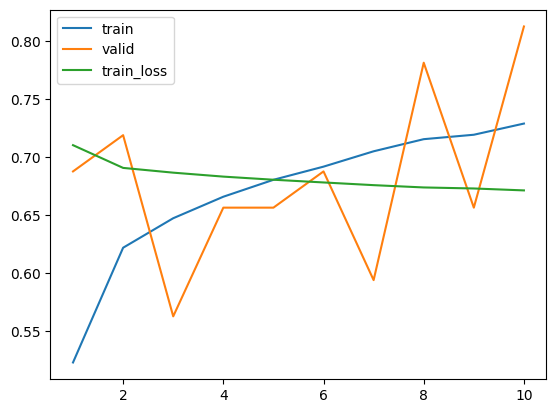

In [283]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_expanded['Review Text'].values
text_sequences.shape

corpus = ' '.join(text_sequences)

tokens = text_to_word_sequence(corpus)

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)

num_words = 4000
vocab_size = num_words

tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

sequences = tok.texts_to_sequences(text_sequences)
minimized_X = pad_sequences(sequences, padding='pre', maxlen=maxlen)
ohe = OneHotEncoder(sparse=False)
minimized_y = ohe.fit_transform(df_expanded['Rating'].to_numpy().reshape(-1,1))

data_set_2 = Data(minimized_X, minimized_y)

input_size = data_set_2.x.shape[1]
print("input_size:", input_size)

output_dim = data_set_2.y.shape[1]
print("Output dim", output_dim)

torch.manual_seed(120)
data_set_2_reduced_size = int(data_set_2.len * 1)
valid_set_size = int(data_set_2_reduced_size * 0.2)
train_set_size = data_set_2_reduced_size - valid_set_size
data_set_2_reduced, _ = torch.utils.data.random_split(data_set_2, [data_set_2_reduced_size, data_set_2.len - data_set_2_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_2_reduced, [train_set_size, data_set_2_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


model2 = Model4(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.MultiLabelSoftMarginLoss()  

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=10
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train_loss')
plt.show()

Continuamos el entrenamiento algunas epochs mas

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


Epoch: 1/200 - Train loss 0.670 - Train accuracy 0.735 - Valid Loss 0.702 - Valid accuracy 0.562
Epoch: 2/200 - Train loss 0.669 - Train accuracy 0.739 - Valid Loss 0.699 - Valid accuracy 0.594
Epoch: 3/200 - Train loss 0.668 - Train accuracy 0.745 - Valid Loss 0.673 - Valid accuracy 0.719
Epoch: 4/200 - Train loss 0.668 - Train accuracy 0.747 - Valid Loss 0.658 - Valid accuracy 0.781
Epoch: 5/200 - Train loss 0.667 - Train accuracy 0.751 - Valid Loss 0.698 - Valid accuracy 0.594
Epoch: 6/200 - Train loss 0.666 - Train accuracy 0.752 - Valid Loss 0.717 - Valid accuracy 0.500
Epoch: 7/200 - Train loss 0.665 - Train accuracy 0.759 - Valid Loss 0.692 - Valid accuracy 0.625
Epoch: 8/200 - Train loss 0.664 - Train accuracy 0.764 - Valid Loss 0.710 - Valid accuracy 0.531
Epoch: 9/200 - Train loss 0.663 - Train accuracy 0.769 - Valid Loss 0.667 - Valid accuracy 0.750
Epoch: 10/200 - Train loss 0.666 - Train accuracy 0.755 - Valid Loss 0.697 - Valid accuracy 0.594
Epoch: 11/200 - Train loss 0.

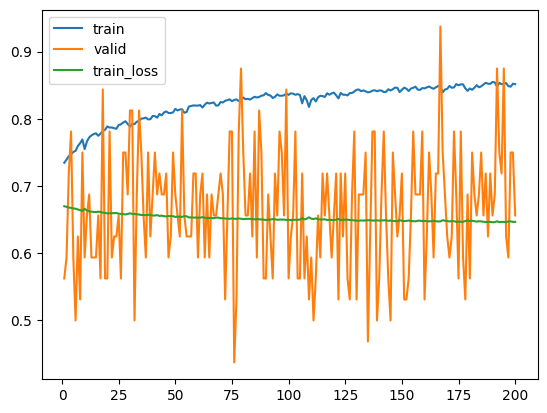

In [284]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=200
                )

epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train_loss')
plt.show()

El acc en validación oscila entre 0.5 y 0.8. Entiendo que se dan tantas oscilaciones por mirar un numero bajo de ejemplos por epoch

In [297]:
torch.save(model2.state_dict(), 'model_4_class_df_expanded.pt')

In [381]:
def predict_rating(model, tokenizer, seed_text):
    output_text = ""
	# generate a fixed number of words
	# Encodeamos
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
	# Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=maxlen, padding='pre')
	# Predicción softmax
    y_hat = model(torch.from_numpy(encoded)).argmax(axis=-1)
    #print(f"Rating predicted: {y_hat[0]}")
    return y_hat[0]

In [341]:
predict_rating(model2, tok, "this is beautiful")

Rating predicted: 3


/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


In [342]:
predict_rating(model2, tok, "AMAZING!")

Rating predicted: 3


/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


Chequeo la distribución de predicciones del modelo

In [397]:
check_items = 10000

count = 0
results = {0: 0, 1:0, 2:0, 3:0, 4:0}
examples = {}
while(count < check_items):
    predicted = predict_rating(model2, tok, df_reviews.iloc[count]['Review Text'])
    results[predicted.item()] = results[predicted.item()] + 1
    examples[predicted.item()] = df_reviews.iloc[count]['Review Text']
    count = count + 1

results, examples

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


({0: 7, 1: 545, 2: 1203, 3: 2730, 4: 5515},
 {4: 'Overall, quite good red skirt, though a little clingy material. good that it has lining. the waist is elastic. xs fits great on me (5\'4", 120lbs).',
  2: "I was very excited to get this but very disappointed once it arrived. the fabric on the back is thin and clingy. i think you'd have to wear a slip underneath. cute design on the front but sadly it's going back.",
  1: 'These are terribly unflattering the wash looks dirty and the rise is not 10.5 like the description says, which is the only reason i gambled on these it is 13".',
  3: 'Beautiful skirt but runs small. not for eveyone- this is for those with flat stomachs. i had to size up from a 6 to an 8 for my stomach to not stick out in this skirt and then it looked to wide on the bottom and lost the slick pencil look. if you are fit and firm this is a gorgeous skirt. it is lined and fabric somewhat heavy.',
  0: 'This dress looks like it could be cute on but when you put it on its j

In [398]:
predict_rating(model2, tok, "the chacket is amazing, made me looks great")

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


tensor(4)

In [407]:
predict_rating(model2, tok, "the shirt is not cute, I look terribly using it. The color is not as the picture, I wish light blue but is dark. Buy this was a bad idea")

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


tensor(2)

In [410]:
predict_rating(model2, tok, "It is the better chacket I ever see in my life")

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


tensor(3)

From amazon (Rating: 2)

In [411]:
predict_rating(model2, tok, "I received the XL shirt (which is the size of my other shirts) and really was unimpressed. The short is a linen/cotton blend but the material felt rather stiff and thick. The black was a good deep shade but the sizing felt off – not wrong around the body but the arms were longer than expected the cuffs gaping and this would make me say that on the product pictures this might be why all show the sleeves rolled up. Or maybe it is because of the lop-sided arms… Not mine, my arms are not lopsided but the left sleeve rode down to cover over the base of the back of my hand, the right went all the way to my fingers – I hope I just got a randomly misshaped one and this is not the norm, but for me, not great.")

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


tensor(3)

From amazon (Rating: 4)

In [412]:
predict_rating(model2, tok, "This cotton linen long sleeve men 's casual shirt is very suitable for wearing in daily life and work, very comfortable and breathable. My husband usually wears the S model, because he likes to wear a little loose, I ordered this L, which is a really soft cotton and linen material, feels very comfortable, and presents his body perfectly. He likes to wear this men 's cotton and linen long-sleeved business shirt, I also like him to wear this cotton and linen shirt, no smell and itching and take care of very convenient, will not appear color and shrinkage of the situation, the seam is also very in place, no extra thread.I highly recommend this long-sleeved linen shirt for men. My husband told me it was the best gift he ever received and he was very happy.")

/var/folders/1d/chtcpg0n5m75kwqdhbfl_yt00000gn/T/ipykernel_12542/2866331658.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(self.fc4(out))


tensor(4)